total pos class (should be 32) = 67

centroids_set shape should be >= seed_set shape. If it doesn't then there is something wrong.
centroids_set shape = 
(209, 10)
seed_set shape = 
(209, 10)
Is there a duplicated index in the unlabelled set?
False
Is there a duplicated index in the seed set?
False
Is there a positive example in our seed set?
True
Do X_unlabelled and y_unlabelled have the same size?
X_unlabelled = 1879,	 y_unlabelled = 1879
Negative example cost = 0.0430622009569378
Positive example cost = 0.9569377990430622
Number of Positive examples in seed set = 9
['iteration', 'f1_score', 'model__C', 'model__class_weight', 'model__gamma', 'model__kernel']
['iteration', 'number of labelled minority examples']
['precision', 'recall']
[0 1]
F1 score = 0.05617977528089888
F1 score = 0.06097560975609757
F1 score = 0.05670103092783506
F1 score = 0.056847545219638244
F1 score = 0.05670103092783506
F1 score = 0.06134969325153375
F1 score = 0.06060606060606061
F1 score = 0.0621118012422360

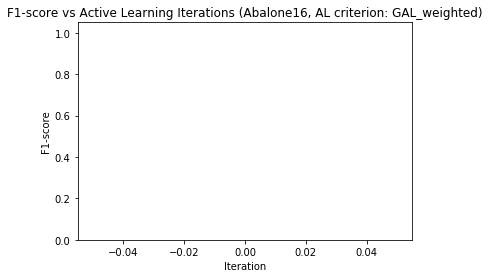

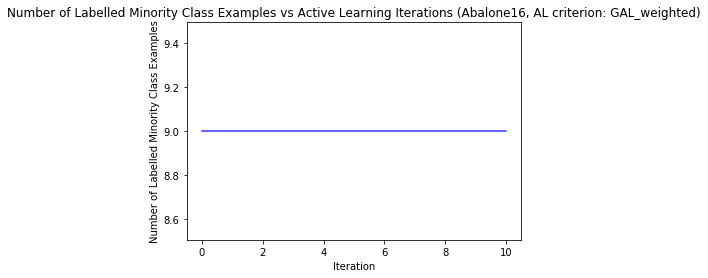

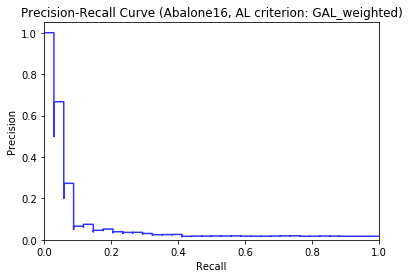

In [6]:
#--------------------------------------------------------------------------------
#
# Project implementation.
#
#--------------------------------------------------------------------------------
# !pip install neupy
# !pip install --upgrade mlxtend
import pandas as pd
from scipy import stats
from scipy.spatial.distance import cdist
import numpy as np
from numpy import array
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, \
    recall_score, roc_curve, precision_recall_curve, make_scorer, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.mixture import GaussianMixture
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelBinarizer
import csv
from random import random
import os
from warnings import simplefilter

# ignore all future warnings.
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

#--------------------------------------------------------------------------------
np.random.seed(0)

#--------------------------------------------------------------------------------
BASE_DIR = F"C:/Users/zalat/Downloads/Directed Studies/Experiments/Abalone19/GAL"
SAVE_DIR = F"C:/Users/zalat/Downloads/Directed Studies/Experiments/Results/"
CSV_FILE_TRAINING = F"abalone_csv.csv"
F1_RESULTS_FMT = "{}_F1_results.csv"
NUM_RESULTS_FMT = "{}_NUM_results.csv"
PR_RE_RESULTS_FMT = "{}_PR_RE_results.csv"
# CSV_FILE_CALIBRATION = F"csv_result-Descriptors_Calibration.csv"
POSITIVE_LABEL = 1
NEGATIVE_LABEL = 0
CLASS_COLUMN = 'class'
N = 4000
init_beta = 0.01 ** (1/float(N))
MAX_ITER = 100000
ABALONE_AGE = 16
    
#--------------------------------------------------------------------------------
class OnlinePipeline(Pipeline):
    def online_fit(self, X, y):
        Xt = X
        for name, transform in self.steps[:-1]:
            Xt = transform.transform(Xt)
        name, estimator = self.steps[-1]
        return estimator.fit(Xt, y)
    
    def bic(self, X):
        name, estimator = self.steps[-1]
        return estimator.bic(X)
    
    def score_samples(self, X):
        name, estimator = self.steps[-1]
        return estimator.score_samples(X)

#--------------------------------------------------------------------------------
def import_csv(file_path):
    return pd.read_csv(file_path)

#--------------------------------------------------------------------------------
def concatenate_frames(frames):
    return pd.concat(frames, ignore_index=True)

#--------------------------------------------------------------------------------
def add_csv_header(file_name, header):
    with open(file_name, 'w') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',', 
                                quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(header)

#--------------------------------------------------------------------------------
def add_csv_row(file_name, row):
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = csv.writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(row)

#--------------------------------------------------------------------------------
def _create_model_instance(model):
    scaler = MinMaxScaler((-1, 1))
    
    return OnlinePipeline([('scaler', scaler),
                           ('model', model)])

#--------------------------------------------------------------------------------
def create_discriminative_model_instance(class_weight=None):
    # Creates an instance of the model with the given error tolerance,
    # regularization hyperparameter C, intercept_scaling for bias and 
    # class_weight 'balanced' for multiplying the cost of each point with the 
    # inverse of its respective class proportion (by default there is no 
    # weighting).
    #
    # !!! NOTE !!!
    # For adding a custom weight to the examples, use a dictionary mapping the
    # class to the cost. 
    #
    # Example: {'P': cost_of_positive, 'N': cost_of_negative}

#     model = LinearSVC(tol=tol, C=C, intercept_scaling=intercept_scaling,
#                       class_weight=class_weight, loss='hinge', max_iter=MAX_ITER)
    
    model = SVC(class_weight=class_weight, probability=True)
    
    # Wrap the model with a calibrated classifier to get Pratt scaled posteriors.
#     model = CalibratedClassifierCV(model)

    return _create_model_instance(model)

#--------------------------------------------------------------------------------
def create_generative_model_instance(n_components=1):
    # Creates an instance of a GMM model with the specified number of gaussian 
    # components.
    model = GaussianMixture(n_components, covariance_type='tied')
    return _create_model_instance(model)

#--------------------------------------------------------------------------------
def calculate_entropy(discriminative_model, unlabelled_X):
    # Returns the entropy of each sample in unlabelled_X with respect to the 
    # given discriminative model. (H(Y|x) for x in unlabelled_X)
    
    # 1) Get P(Ymin|x).
    posterior_probs = discriminative_model.predict_proba(unlabelled_X)[:, -1]
    
    # 2) Calculate entropy (H(Y|x)).
    entropy = np.multiply(posterior_probs, np.log(posterior_probs))
    
    return entropy

#--------------------------------------------------------------------------------
def _uncertainty_score(discriminative_model, generative_model,
                       unlabelled_X, *pargs, **kwargs):
    # Returns the entropy of each sample in unlabelled_X with respect to the 
    # given discriminative model. (H(Y|x) for x in unlabelled_X)
    return calculate_entropy(discriminative_model, unlabelled_X)

#--------------------------------------------------------------------------------
def _likelihood_score(discriminative_model, generative_model,
                       unlabelled_X, *pargs, **kwargs):
    # Returns (1 - P(x|Ymin)) for each point x in unlabelled_X.
    
    # Get the weighted log likelihood of each sample. (log(P(x|Ymin))).
    log_likelihood = generative_model.score_samples(unlabelled_X)
    
    # Convert to the likelihood. (P(x|Ymin)).
    likelihood = np.exp(log_likelihood) 
    
    return 1 - likelihood
    
#--------------------------------------------------------------------------------
def _GAL_score(discriminative_model, generative_model, unlabelled_X, iteration,
               *pargs, **kwargs):
    # Calculates the GAL score using the discriminative and generative model using
    # the unlabelled batch provided in unlabelled_X, and returns the score of
    # each point in the batch.
    
    # Calculate entropy (H(Y|x)).
    entropy = calculate_entropy(discriminative_model, unlabelled_X)
    
     # Get the weighted log likelihood of each sample. (log(P(x|Ymin))).
    log_likelihood = generative_model.score_samples(unlabelled_X)
    
    # Convert to the likelihood. (P(x|Ymin)).
    likelihood = np.exp(log_likelihood) 
    
    # Compute P(x|Ymin)^Beta(iteration).
    if random() > 0.05:
        exploitation_factor = likelihood ** (init_beta ** float(iteration))
    else:
        exploitation_factor = (1 - likelihood) ** (init_beta ** float(iteration))
    
    # Score = H(Y|x) * P(x|Ymin) ^ Beta(t).
    score = np.multiply(entropy, exploitation_factor)
    
    return score

#--------------------------------------------------------------------------------
def _select_point_from_batch(discriminative_model, generative_model, 
                             unlabelled_df, iteration, scoring_function):
    # Calculates the score associated with each point in a batch of 59 points
    # from the unlabelled_df points at a given iteration and returns the new
    # set of unlabelled points (U - selected_point) and selected point along 
    # with its respective class. The score is calculated by using the passed
    # scoring function.
    batch = unlabelled_df.sample(min(59, len(unlabelled_df)))
    unlabelled_X = batch.drop([CLASS_COLUMN], 1)
    unlabelled_y = batch[CLASS_COLUMN]
    
    score = scoring_function(discriminative_model, generative_model,
                             unlabelled_X, iteration)
    
    selected_point_idx = np.argmax(score)
    
    # Get the selected point and class label.
    selected_point = unlabelled_X.iloc[selected_point_idx]
    selected_class = unlabelled_y.iloc[selected_point_idx]
    
    # Remove the selected point from the unlabelled pool.
    new_set = unlabelled_df.drop(selected_point.name)
    
    return new_set, selected_point, selected_class

#--------------------------------------------------------------------------------
def select_point_from_batch_GAL(discriminative_model, generative_model, 
                                unlabelled_df, iteration):
    # Calculates the GAL score associated with each point in a batch of 59 points
    # from the unlabelled_df points at a given iteration and returns the new
    # set of unlabelled points (U - selected_point) and the selected point along 
    # with its respective class.
    return _select_point_from_batch(discriminative_model, generative_model,
                                    unlabelled_df, iteration,
                                    _GAL_score)

#--------------------------------------------------------------------------------
def select_point_from_batch_uncertainty(discriminative_model, generative_model, 
                                        unlabelled_df, iteration):
    return _select_point_from_batch(discriminative_model, generative_model,
                                    unlabelled_df, iteration,
                                    _uncertainty_score)

#--------------------------------------------------------------------------------
def select_point_from_batch_likelihood(discriminative_model, generative_model, 
                                       unlabelled_df, iteration):
    return _select_point_from_batch(discriminative_model, generative_model,
                                    unlabelled_df, iteration,
                                    _likelihood_score)

#--------------------------------------------------------------------------------
def train_models_using_selected_point(discriminative_model, generative_model,
                                      selected_X, selected_y, new_labelled_X,
                                      new_labelled_y, labelled_positives):
    # Returns updated generative_model and current set of labelled positives.
    
    # Fit the new point in the SVM.
    # EDITED (was using online_fit)
    discriminative_model.fit(new_labelled_X, 
                             new_labelled_y.values.ravel())
    
    # New labelled positives set = labelled_positive_set U selected_point iff
    # selected_point = positive.
    if selected_y == POSITIVE_LABEL:
        labelled_positives = labelled_positives.append(selected_X)

        # Get the best generative model that describes the data.
        generative_model = get_optimal_generative_model(labelled_positives)
    
    return generative_model, labelled_positives

#--------------------------------------------------------------------------------
def get_optimal_generative_model(all_minority_X):
    # Find the optimal number of components for our GMM model given the current
    # set of labelled minority examples and return the best model.
    n_components = np.arange(1, min(20, len(all_minority_X)))
    models = [create_generative_model_instance(n).fit(all_minority_X) 
              for n in n_components]
    bics = [m.bic(all_minority_X) for m in models]
    return models[bics.index(min(bics))]

#--------------------------------------------------------------------------------
def closest_point(centroid, points):
    # Find the closest point from a list of points.
    distances = (points - np.array(centroid)).pow(2).sum(1).pow(0.5)
    minimum_index = distances.idxmin()
        
    return points.loc[minimum_index]

#--------------------------------------------------------------------------------
def get_seed_set(data_X, data_y):
    # Splits the set of data points into 10% and 90%, where the 10% are points
    # selected by selecting the points that are closest to the mode of each
    # cluster (where 10% of the size of the dataset is the number of clusters).
    # The clusters are created by agglomerative hierarical clustering using the
    # ward linkage (i.e. minimal variance of each cluster).
    
    scaler = MinMaxScaler((-1, 1))
    scaled_X = pd.DataFrame(scaler.fit_transform(data_X), index=data_X.index,
                            columns=data_X.columns)
    
    # Here we are wrapping the model with a normalizer so no feature is
    # considered more important than another feature.
    clustering = _create_model_instance(AgglomerativeClustering(
        round(0.1*len(scaled_X))))
    
    # Get the cluster assignment of each point.
    cluster_assignments = clustering.fit_predict(scaled_X)
    
    nearestCentroid = NearestCentroid()
    nearestCentroid.fit(scaled_X, cluster_assignments)
    centroids = nearestCentroid.centroids_
    
    seed_set = pd.DataFrame()
    for centroid in centroids:
        seed_set = seed_set.append(closest_point(centroid, scaled_X))
    
    # Make sure we don't have duplicates in our seed set.
    seed_set = seed_set.drop_duplicates()
    
    print('centroids_set shape should be >= seed_set shape. If it doesn\'t then'
          ' there is something wrong.')
    print('centroids_set shape = ')
    print(centroids.shape)
    
    print('seed_set shape = ')
    print(seed_set.shape)
    
    return data_X[data_X.index.isin(seed_set.index)], \
           data_y[data_y.index.isin(seed_set.index)]
    
#--------------------------------------------------------------------------------
def calculate_f1_score(discriminative_model, X_test, y_test):
    y_pred = discriminative_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print('F1 score = {}'.format(f1))
    
    return f1

#--------------------------------------------------------------------------------
def calculate_pr_re_score(discriminative_model, X_test, y_test):
    y_pred = discriminative_model.predict(X_test)
    pr = precision_score(y_test, y_pred)
    re = recall_score(y_test, y_pred)
    return [pr, re]

#--------------------------------------------------------------------------------
def plot_pr_curve(discriminative_model, X_test_, y_test, dataset_name, 
                  criterion_name):
    y_pred_prob = discriminative_model.predict_proba(X_test)
    # Plot the Precision-Recall curve.
    pr, re, thresholds = precision_recall_curve(y_test, y_pred_prob[:, 1],
                                                pos_label=POSITIVE_LABEL)
    print('-' * 80)
    plt.figure()
    plt.step(re, pr, color='b', alpha=0.8, where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve ({}, AL criterion: {})'
              .format(dataset_name, criterion_name))
    plt.savefig(os.path.join(SAVE_DIR, 'Pr_Re_{}_{}.jpg'
                             .format(dataset_name, criterion_name)))

    print('-' * 80)
    
#--------------------------------------------------------------------------------
def plot_F1_curve(F1_scores, dataset_name, criterion_name):
    print('-' * 80)
    plt.figure()
    plt.step(range(0, len(F1_scores)), F1_scores, color='b', 
             alpha=0.8, where='post')

    plt.xlabel('Iteration')
    plt.ylabel('F1-score')
    plt.ylim([0.0, 1.05])
    plt.title('F1-score vs Active Learning Iterations ({}, AL criterion: {})'
              .format(dataset_name, criterion_name))
    plt.savefig(os.path.join(SAVE_DIR, 'F1_curve_{}_{}.jpg'
                             .format(dataset_name, criterion_name)))

    print('-' * 80)
    
#--------------------------------------------------------------------------------
def plot_minority_examples_curve(num_positive_examples, dataset_name, 
                                 criterion_name):
    print('-' * 80)
    plt.figure()
    plt.step(range(0, len(num_positive_examples)), num_positive_examples, 
             color='b', alpha=0.8, where='post')

    plt.xlabel('Iteration')
    plt.ylabel('Number of Labelled Minority Class Examples')
    plt.title('Number of Labelled Minority Class Examples vs Active Learning '
              'Iterations ({}, AL criterion: {})'
              .format(dataset_name, criterion_name))
    plt.savefig(os.path.join(SAVE_DIR, 'minority_examples_curve_{}_{}.jpg'
                             .format(dataset_name, criterion_name)))

    print('-' * 80)

#--------------------------------------------------------------------------------
def evaluate_active_learning_criterion(criterion, X_seed, y_seed, X_unlabelled,
                                       y_unlabelled, X_test, y_test, 
                                       class_weight=None, 
                                       dataset_name='ProteinMethylation',
                                       criterion_name=''):
    
    # Initialize the generative model that best describes the positive examples
    # we have.
    labelled_positives = X_seed.loc[y_seed[CLASS_COLUMN] == POSITIVE_LABEL]
    generative_model = get_optimal_generative_model(labelled_positives)
    
    # Initialize the discriminative model that fits the seed set.
    X_labelled = X_seed
    y_labelled = y_seed
    
    svc_model = create_discriminative_model_instance(
        class_weight=class_weight)
    param_dist = {
          'model__C': stats.expon(scale=100),
          'model__gamma': ['auto'], 
          'model__kernel': ['rbf', 'poly'],
          'model__class_weight': [class_weight],
    }
    discriminative_model = RandomizedSearchCV(svc_model, 
                                              param_distributions=param_dist,
                                              cv=5,
                                              n_iter=100,
                                              n_jobs=2,
                                              scoring='f1_macro')
    
    discriminative_model.fit(X_seed, y_seed.values.ravel())

    F1_RESULTS_CSV = F1_RESULTS_FMT.format(dataset_name)
    NUM_RESULTS_CSV = NUM_RESULTS_FMT.format(dataset_name)
    PR_RE_RESULTS = PR_RE_RESULTS_FMT.format(dataset_name)

    add_csv_header(F1_RESULTS_CSV, ['iteration', 'f1_score'] + 
                   [key for key, value in sorted(discriminative_model
                                                 .best_params_.items())])
    
    add_csv_header(NUM_RESULTS_CSV, ['iteration', 
                                     'number of labelled minority examples'])
    
    add_csv_header(PR_RE_RESULTS, ['precision', 'recall'])
    
    
    print(discriminative_model.classes_)
    # Iterate through the entire set of unlabelled data.
    # On each iteration do the following:
    # 1) select the most informative point based on the criterion.
    # 2) train the models.
    # 3) Record the number of positive examples in the current labelled set.
    # 4) Record the F1 score of the classifier at the end of each iteration.
    num_positive_examples = []
    F1_scores = []
    unlabelled_df = X_unlabelled.join(y_unlabelled)
    for iteration in range(0, len(unlabelled_df)):
        unlabelled_df, selected_X, selected_y = criterion(discriminative_model, 
                                                          generative_model, 
                                                          unlabelled_df, 
                                                          iteration)
        # Add the new selected point to the labelled set of data.
        X_labelled = X_labelled.append(selected_X)
        y_labelled = y_labelled.append(pd.Series({CLASS_COLUMN: selected_y}, 
                                                 name=selected_X.name))
        # print('Selected class = {}'.format(selected_y))
        
        # Train the models and update the set of labelled positives if the new
        # example is positive.
        generative_model, labelled_positives = train_models_using_selected_point(
            discriminative_model, generative_model, selected_X, selected_y, 
            X_labelled, y_labelled, labelled_positives)
        
        add_csv_row(NUM_RESULTS_CSV, [iteration, len(labelled_positives)])
        
        num_positive_examples.append(len(labelled_positives))
        
        f1_score = calculate_f1_score(discriminative_model, X_test, y_test)
        add_csv_row(F1_RESULTS_CSV, [iteration, f1_score] +
                   [value for key, value in sorted(discriminative_model
                                                   .best_params_.items())])
        
        F1_scores.append(f1_score)
        # Uncomment this for a test run.
#         if iteration == 10:
#             break
    
    # Plot the F-score vs iterations curve.
    plot_F1_curve(F1_scores, dataset_name, criterion_name)
    
    # Plot the number of minority examples in labelled set vs iterations curve.
    plot_minority_examples_curve(num_positive_examples, dataset_name, 
                                 criterion_name)

    # Plot the precision recall curve of the final classifier.
    plot_pr_curve(discriminative_model, X_test, y_test, dataset_name,
                  criterion_name)
    
    add_csv_row(PR_RE_RESULTS, calculate_pr_re_score(discriminative_model, 
                                                     X_test, y_test))

#--------------------------------------------------------------------------------
def get_precision_std(tp, n):
    p = float(tp) / n
    variance_of_sum = p * (1 - p) / n
    std = variance_of_sum ** 0.5
    return std

#--------------------------------------------------------------------------------
def get_abalone():
    """Loads abalone dataset, maps gender feature to binary features, adds
    new label to create abalone19 imbalanced binary classification dataset."""
    ORIGINAL_CLASS_COL = 'Class_number_of_rings'
    raw_data = import_csv(csv_path_training)
    genders = list(raw_data.ix[:, 'Sex'])
    cts_data = raw_data.drop(labels='Sex', axis=1)

    # initialize & fit preprocesser
    lbz = LabelBinarizer()
    lbz.fit(genders)

    # encode categorical var
    encoded_genders = pd.DataFrame(lbz.transform(genders))
    encoded_genders.columns = ['Sex_' + k for k in lbz.classes_]

    # recombine encoded data & return
    new_data = pd.concat(objs=[encoded_genders, cts_data], axis=1)
    new_data[CLASS_COLUMN] = raw_data[ORIGINAL_CLASS_COL].map(
        lambda k: 1 if k == ABALONE_AGE else 0)               # binary clf task
    
    new_data = new_data.drop(ORIGINAL_CLASS_COL, axis=1)

    pos_recs = new_data[CLASS_COLUMN].sum()
    print('total pos class (should be 32) = {}\n'.format(
        pos_recs))

    return new_data

#--------------------------------------------------------------------------------
if __name__ == "__main__":
    csv_path_training = os.path.join(BASE_DIR, CSV_FILE_TRAINING)
#     csv_path_calibration = os.path.join(BASE_DIR, CSV_FILE_CALIBRATION)

    # All of our data collected.
    data = get_abalone()
    
    # Drop id column from data.
#     data = data.drop(['id'], 1)

    # Separate features from their corresponding class.
    y = data.pop(CLASS_COLUMN).to_frame()
    X = data
    
    # Save 50% of the data for testing.
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                        test_size=0.5)
    
    # Get the seed set using agglomeratice hierarichal clustering.
    X_seed, y_seed = get_seed_set(X_train, y_train)
    
    # Initialize the unlabelled set of data.
    X_unlabelled = X_train[~X_train.isin(X_seed).all(1)]
    y_unlabelled = y_train[y_train.index.isin(X_unlabelled.index)]
    
    print('Is there a duplicated index in the unlabelled set?')
    print(True in X_unlabelled.index.duplicated())
    
    print('Is there a duplicated index in the seed set?')
    print(True in X_seed.index.duplicated())
    
    print('Is there a positive example in our seed set?')
    print(y_seed.isin([POSITIVE_LABEL]).any().any())
    
    print('Do X_unlabelled and y_unlabelled have the same size?')
    print('X_unlabelled = {},\t y_unlabelled = {}'.format(len(X_unlabelled),
                                                          len(y_unlabelled)))
    
    # Segregate the negative and positive seed examples.
    negative_seed = X_seed.loc[y_seed[CLASS_COLUMN] != POSITIVE_LABEL]
    positive_seed = X_seed.loc[y_seed[CLASS_COLUMN] == POSITIVE_LABEL]
    
    # Negative cost = # of pos in seed set/seed set size
    negative_cost = len(positive_seed) / len(X_seed)
    
    # Positive cost = # of negative in seed set/seed set size
    positive_cost = len(negative_seed) / len(X_seed)
    
    print('Negative example cost = {}'.format(negative_cost))
    print('Positive example cost = {}'.format(positive_cost))
    
    print('Number of Positive examples in seed set = {}'
          .format(len(positive_seed)))
    
    criterion = select_point_from_batch_GAL
    evaluate_active_learning_criterion(criterion, X_seed, y_seed, X_unlabelled,
                                       y_unlabelled, X_test, y_test, 
                                       class_weight={1: len(negative_seed) / float(len(positive_seed))},
                                       dataset_name='Abalone16',
                                       criterion_name='GAL_weighted')